# Scheduling Extra Credit Writeup

### Introduction
This is the Jupyter notebook for our custom scheduler writeup. We start by importing necessary packages and organizing our collected data (in `/extracredit/stats`) into data frames and creating probability and cumulative distributions from them.

### Data Collection
Since the writeup mentions:

 *"Since we are running xv6 on top of an emulator such as qemu rather than on bare-metal, results may strongly vary depending on host device and the performance capabilities of the emulator."*
 
We made sure to collect all of our data on Gal's machine (MacBook Pro 2023, 16GB RAM, M2 chip) and 
simulate it through qemu. We used the provided workload in `workload.c` on 1, 2, 3, and 4 cores for data collection.

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

dir = './stats'
sched_names = ['fifo', 'rr', 'custom']
cpus = [1,2,3,4]

# dictionaries for organization, will come into use when visualizing
pdf = {}
cdf = {}
bins_dict = {}

# create pdfs and cdfs
for sched_name in sched_names:
    for i in cpus:
        file = f'{sched_name}{i}_stats.csv'
        filepath = os.path.join(dir, file) # locate proper file
        responses = pd.read_csv(filepath)['response'].to_numpy()

        key = f'{sched_name}{i}'   
        count, bins_count = np.histogram(responses, bins=100)
        pdf[key] = count / sum(count)
        cdf[key] = np.cumsum(pdf[key])
        bins_dict[key] = bins_count

""""
Prints pscores:
    category: "rr", "fifo", or "custom"
    scores: array of desired scores to print: [1, 50, 95] for example
"""
def print_pscores(category, scores):
    print(' ' * 19 + f'{category} pscores')
    print('-----------------------------------------------------')
    for i, key in enumerate(pdf.keys()):
        if key.startswith(category):
            score_string = "\t".join([f'p{score}: {np.percentile(bins_dict[key], score):.2f}' for score in scores])
            print(f'{key} | {score_string}')
            print('-----------------------------------------------------')


### FIFO PDF/CDF Plots
This code extracts the FIFO data for end-to-end latency and plots the distributions below. 

                   fifo pscores
-----------------------------------------------------
fifo1 | p50: 3037.00	p95: 5681.20	p99: 5916.24
-----------------------------------------------------
fifo2 | p50: 1709.00	p95: 3239.90	p99: 3375.98
-----------------------------------------------------
fifo3 | p50: 1101.00	p95: 2080.20	p99: 2167.24
-----------------------------------------------------
fifo4 | p50: 967.00	p95: 1825.60	p99: 1901.92
-----------------------------------------------------


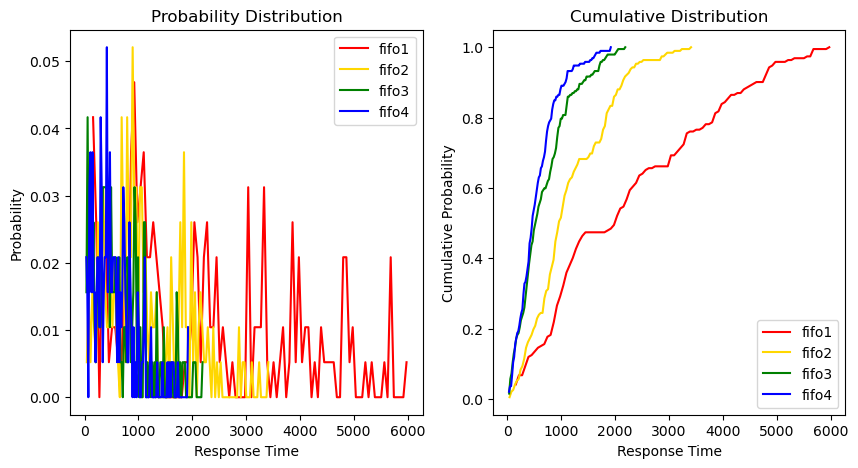

In [113]:
print_pscores('fifo', [50, 95, 99]) 

plt.figure(figsize=(10, 5))

colors = ['red', 'gold', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta']


plt.subplot(1, 2, 1)
for i, key in enumerate(pdf.keys()):
    if key.startswith('fifo'):
        plt.plot(bins_dict[key][1:], pdf[key], color=colors[i % len(colors)], label=key)
plt.title("Probability Distribution")
plt.xlabel("Response Time")
plt.ylabel("Probability")
plt.legend()

plt.subplot(1, 2, 2)
for i, key in enumerate(cdf.keys()):
    if key.startswith('fifo'):
        plt.plot(bins_dict[key][1:], cdf[key], color=colors[i % len(colors)], label=key)
plt.title("Cumulative Distribution")
plt.xlabel("Response Time")
plt.ylabel("Cumulative Probability")
plt.legend()

plt.show()

### RR PDF/CDF Plots
This code extracts the round robin data and plots the end to latency distributions below.

                   rr pscores
-----------------------------------------------------
rr1 | p50: 1561.50	p95: 2947.05	p99: 3070.21
-----------------------------------------------------
rr2 | p50: 1055.50	p95: 1996.45	p99: 2080.09
-----------------------------------------------------
rr3 | p50: 868.50	p95: 1642.05	p99: 1710.81
-----------------------------------------------------
rr4 | p50: 840.00	p95: 1591.50	p99: 1658.30
-----------------------------------------------------


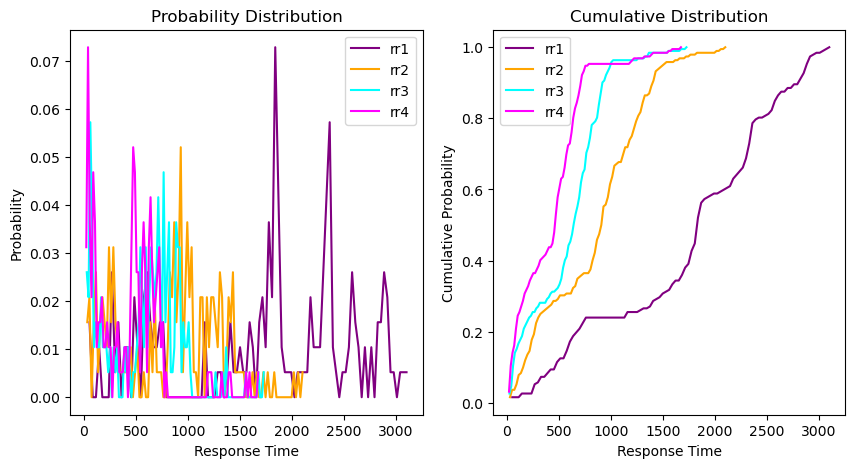

In [114]:
print_pscores('rr', [50, 95, 99])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for i, key in enumerate(cdf.keys()):
    if key.startswith('rr'):
        plt.plot(bins_dict[key][1:], pdf[key], color=colors[i % len(colors)], label=key)
plt.title("Probability Distribution")
plt.xlabel("Response Time")
plt.ylabel("Probability")
plt.legend()

plt.subplot(1, 2, 2)
for i, key in enumerate(cdf.keys()):
    if key.startswith('rr'):
        plt.plot(bins_dict[key][1:], cdf[key], color=colors[i % len(colors)], label=key)
plt.title("Cumulative Distribution")
plt.xlabel("Response Time")
plt.ylabel("Cumulative Probability")
plt.legend()

plt.show()

## Custom Scheduler
Now that we have our baseline latencies plotted, we can discuss our custom scheduler approach. Our overarching idea was to prioritize processes that had received less time on the CPU, much like the "Deep Learning" workflow discussed in lecture. We were heavily inspired by CFS in designing our scheduling algorithm.

An initial approach we explored used a priority system in which process start with a very high priority (ie 1000), and the priority naturally decays over time, thus prioritizing newer processes. Another approach we explored was using multiple queues, where each queue would allow a process to be re-scheduled for multiple time slices (i.e. an 8-timeslice, 4-timeslice, and 1-timeslice queue), and processes would eventually be demoted to less desireable queues as time went on.

We ultimately decided to pursue an implementation that used the execution time statistic, and always picked the runnable process with the lowest `execution_time` at each time slice to provide opportunities for fairness.

We decided against using an AVL or a Red-Black tree (like in CFS) in our implementation because we found the implementation of such a data structure too difficult to manage safely. Instead, we decided to make use of a MinHeap (see `heap.c`). The MinHeap holds pointers to processes in the ptable, and entries in the heap are ordered based on the `execution_time` of the process to which the pointer points. Upon entering the scheduler, the process with the lowest execution time (at the root of the heap) is selected to run. 

In our original FIFO implementation, to find the process with the highest priority, we decided to go with the simplest approach: iterate through all of the processes in the ptable and find the one with the lowest timestamp. Looping through `NPROC` entries is inefficient, so for the custom scheduler convenience and speed, we had enough time to implement a custom minheap in `heap.c` to use in our custom scheduler. \

Using this heap, rather than brute forcing our way through the ptable in search of the process with the lowest `execution_time` substantially increased performance (reduced end-to-end latencies). This is because end-to-end latencies not only depend on the scheduling algorithm, but also upon the associated overhead of scheduling a new process (the  temporal cost of selecting a new process).  \

\
The new custom scheduler interacts with xv6 at 3 distinct locations:
- In `pinit()` we initialize our MinHeap (which sets `heap_initialized = 1` to ensure consistency among cores)
- In `yield()` we add processes with the custom scheduling policy using `heap_push()`
- In `scheduler()` we pop from the heap to find the process with lowest execution time

Nits:
- The custom policy takes precedence over FIFO and RR
- Whenever we use the heap, we make sure to use `ptable.lock` to avoid data races.

![Visualization of our MinHeap](./diagram_small.png)


### Custom Scheduler PDF/CDF Plots
This code extracts the round robin data and plots the end to latency distributions below.

                   custom pscores
-----------------------------------------------------
custom1 | p50: 1282.50	p95: 2407.05	p99: 2507.01
-----------------------------------------------------
custom2 | p50: 794.00	p95: 1501.40	p99: 1564.28
-----------------------------------------------------
custom3 | p50: 717.50	p95: 1356.95	p99: 1413.79
-----------------------------------------------------
custom4 | p50: 666.50	p95: 1260.95	p99: 1313.79
-----------------------------------------------------


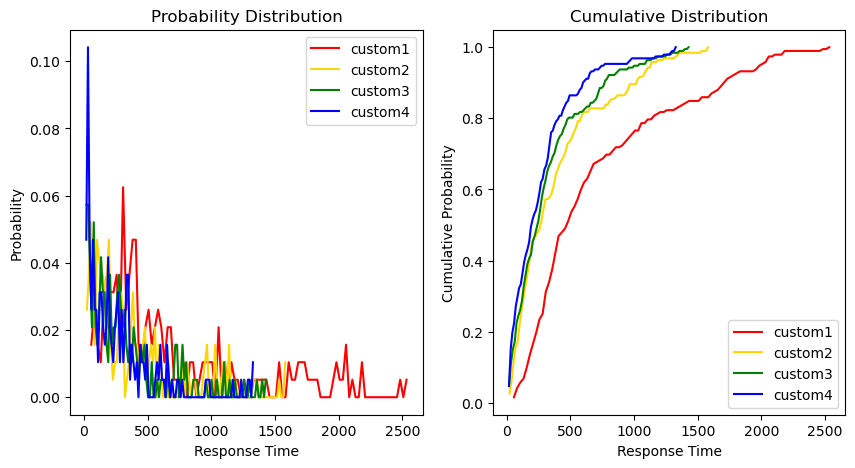

In [115]:
print_pscores('custom', [50, 95, 99])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i, key in enumerate(cdf.keys()):
    if key.startswith('custom'):
        plt.plot(bins_dict[key][1:], pdf[key], color=colors[i % len(colors)], label=key)
plt.title("Probability Distribution")
plt.xlabel("Response Time")
plt.ylabel("Probability")
plt.legend()

plt.subplot(1, 2, 2)
for i, key in enumerate(cdf.keys()):
    if key.startswith('custom'):
        plt.plot(bins_dict[key][1:], cdf[key], color=colors[i % len(colors)], label=key)
plt.title("Cumulative Distribution")
plt.xlabel("Response Time")
plt.ylabel("Cumulative Probability")
plt.legend()

plt.show()

## Putting it all together
In this section we plot the CDFs of every scheduling strategy together seperated by the number of processors it was ran wit.

### Performance
By observing the CDFs and the pscores, our custom scheduler beats FIFO and RR for the provided workload in the pscores (50, 95, and 99). Upon examining the graphs below, it is clear our custom scheduler consistently outperforms both FIFO and RR in any situation.


 <table style="border-collapse: collapse; width: 90%;" border="1">
    <tbody>
        <tr>
            <td style="text-align: center;" rowspan="2"></td>
            <td style="text-align: center;" colspan="4">p50 Scores</td>
            <td style="text-align: center;" colspan="4">p95 scores</td>
            <td style="text-align: center;" colspan="4">p99 Scores</td>
        </tr>
        <tr>
            <td style="text-align: center;">1 core</td>
            <td style="text-align: center;">2 cores</td>
            <td style="text-align: center;">3 cores</td>
            <td style="text-align: center;">4 cores</td>
            <td style="text-align: center;">1 core</td>
            <td style="text-align: center;">2 cores</td>
            <td style="text-align: center;">3 cores</td>
            <td style="text-align: center;">4 cores</td>
            <td style="text-align: center;">1 core</td>
            <td style="text-align: center;">2 cores</td>
            <td style="text-align: center;">3 cores</td>
            <td style="text-align: center;">4 cores</td>
        </tr>
        <tr>
            <td style="text-align: center;">FIFO</td>
            <td style="text-align: center;">3037.00</td>
            <td style="text-align: center;">1709.00</td>
            <td style="text-align: center;">1101.00</td>
            <td style="text-align: center;">967.00</td>
            <td style="text-align: center;">5681.20</td>
            <td style="text-align: center;">3239.90</td>
            <td style="text-align: center;">2080.20</td>
            <td style="text-align: center;">1825.60</td>
            <td style="text-align: center;">5916.24</td>
            <td style="text-align: center;">3375.98</td>
            <td style="text-align: center;">2167.24</td>
            <td style="text-align: center;">1901.92</td>
        </tr>
        <tr>
            <td style="text-align: center;">RR</td>
            <td style="text-align: center;">1561.50</td>
            <td style="text-align: center;">1055.50</td>
            <td style="text-align: center;">868.50</td>
            <td style="text-align: center;">840.00</td>
            <td style="text-align: center;">2947.05</td>
            <td style="text-align: center;">1996.45</td>
            <td style="text-align: center;">1642.05</td>
            <td style="text-align: center;">1591.50</td>
            <td style="text-align: center;">3070.21</td>
            <td style="text-align: center;">2080.09</td>
            <td style="text-align: center;">1710.81</td>
            <td style="text-align: center;">1658.30</td>
        </tr>
        <tr>
            <td style="text-align: center;">Custom</td>
            <td style="text-align: center;">1282.50</td>
            <td style="text-align: center;">794.00</td>
            <td style="text-align: center;">717.50</td>
            <td style="text-align: center;">666.50</td>
            <td style="text-align: center;">2407.05</td>
            <td style="text-align: center;">1501.40</td>
            <td style="text-align: center;">1356.95</td>
            <td style="text-align: center;">1260.95</td>
            <td style="text-align: center;">2507.01</td>
            <td style="text-align: center;">1564.28</td>
            <td style="text-align: center;">1413.79</td>
            <td style="text-align: center;">1313.79</td>
        </tr>
    </tbody>
</table>

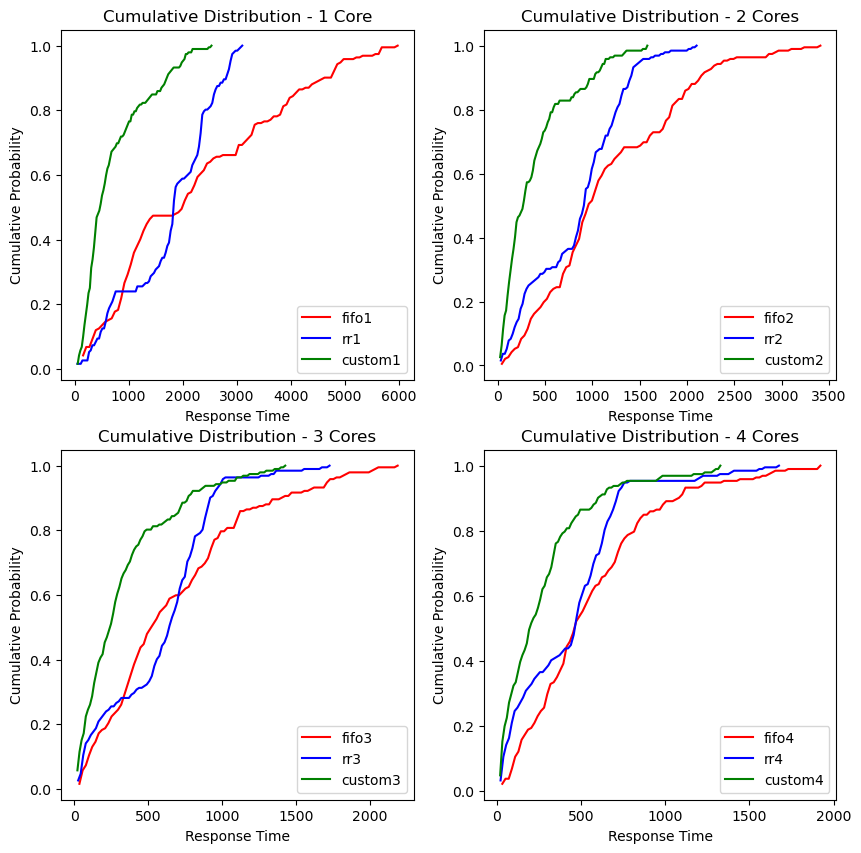

In [116]:
color_mapping = {
    'fifo1': 'red',
    'rr1': 'blue',
    'custom1': 'green',
    'fifo2': 'red',
    'rr2': 'blue',
    'custom2': 'green',
    'fifo3': 'red',
    'rr3': 'blue',
    'custom3': 'green',
    'fifo4': 'red',
    'rr4': 'blue',
    'custom4': 'green'
}

def plot(cores):
    if cores > 4:
        return
    plt.subplot(2, 2, cores)
    plt.title(f"Cumulative Distribution - {cores} Core{'s' if cores > 1 else ''}")
    plt.xlabel("Response Time")
    plt.ylabel("Cumulative Probability")

plt.figure(figsize=(10, 10))
for key in cdf.keys():
    if key in color_mapping.keys():
        if '1' in key:
            plot(1)
        elif '2' in key:
           plot(2)
        elif '3' in key:
            plot(3)
        elif '4' in key:
            plot(4)

        plt.plot(bins_dict[key][1:], cdf[key], color=color_mapping[key], label=key)
        plt.legend()
